<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 5


## NLP and Machine Learning on [travel.statsexchange.com](http://travel.stackexchange.com/) data

---

In Project 7 you'll be doing NLP and machine learning on post data from stackexchange's travel subdomain. 

This project is setup like a mini Kaggle competition. You are given the training data and when projects are submitted your model will be tested on the held-out testing data. There will be prizes for the people who build models that perform best on the held out test set!

---

## Notes on the data

The data is again compressed into the `.7z` file format to save space. There are 6 .csv files and one readme file that contains some information on the fields.

    posts_train.csv
    comments_train.csv
    users.csv
    badges.csv
    votes_train.csv
    tags.csv
    readme.txt
    
The data is located in your datasets folder:

    DSI-SF-2/datasets/stack_exchange_travel.7z
    
If you're interested in where this data came from and where to get more data from other stackexchange subdomains, see here:

https://ia800500.us.archive.org/22/items/stackexchange/readme.txt


### Recommended Utilities for .7z

- For OSX [Keka](http://www.kekaosx.com/en/) or [The Unarchiver](http://wakaba.c3.cx/s/apps/unarchiver.html). 
- For Windows [7-zip](http://www.7-zip.org/) is the standard. 
- For Linux try the `p7zip` utility.  `sudo apt-get install p7zip`.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import gensim
from gensim import corpora, models, similarities
from bs4 import BeautifulSoup

%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
badges = pd.read_csv("/Users/lana/Desktop/Lana-DSI/datasets/stack_exchange_travel/badges.csv")
comments_train = pd.read_csv("/Users/lana/Desktop/Lana-DSI/datasets/stack_exchange_travel/comments_train.csv")
posts_train = pd.read_csv("/Users/lana/Desktop/Lana-DSI/datasets/stack_exchange_travel/posts_train.csv")
tags = pd.read_csv("/Users/lana/Desktop/Lana-DSI/datasets/stack_exchange_travel/tags.csv")
users = pd.read_csv("/Users/lana/Desktop/Lana-DSI/datasets/stack_exchange_travel/users.csv")
votes_train = pd.read_csv("/Users/lana/Desktop/Lana-DSI/datasets/stack_exchange_travel/votes_train.csv")\

In [3]:
print "Badges:", badges.columns
print "Comments: ", comments_train.columns
print "Post: ", posts_train.columns
print "Tags: ", tags.columns
print "Users: ", users.columns
print "Votes: ", votes_train.columns

Badges: Index([u'Class', u'Date', u'Id', u'Name', u'TagBased', u'UserId'], dtype='object')
Comments:  Index([u'CreationDate', u'Id', u'PostId', u'Score', u'Text',
       u'UserDisplayName', u'UserId'],
      dtype='object')
Post:  Index([u'AcceptedAnswerId', u'AnswerCount', u'Body', u'ClosedDate',
       u'CommentCount', u'CommunityOwnedDate', u'CreationDate',
       u'FavoriteCount', u'Id', u'LastActivityDate', u'LastEditDate',
       u'LastEditorDisplayName', u'LastEditorUserId', u'OwnerDisplayName',
       u'OwnerUserId', u'ParentId', u'PostTypeId', u'Score', u'Tags', u'Title',
       u'ViewCount'],
      dtype='object')
Tags:  Index([u'Count', u'ExcerptPostId', u'Id', u'TagName', u'WikiPostId'], dtype='object')
Users:  Index([u'AboutMe', u'AccountId', u'Age', u'CreationDate', u'DisplayName',
       u'DownVotes', u'Id', u'LastAccessDate', u'Location', u'ProfileImageUrl',
       u'Reputation', u'UpVotes', u'Views', u'WebsiteUrl'],
      dtype='object')
Votes:  Index([u'BountyAmount',

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 1. Use LDA to find what topics are discussed on travel.stackexchange.com.

---

Text can be found in the posts and the comments datasets. The `ParentId` column in the posts dataset indicates what the "question" post was for a given post. Comment text can be merged onto the post they are part of with the `PostId` field.

The text may have some HTML tags. BeautifulSoup has convenient ways to get rid of markup or extract text if you need to. You can also parse the strings yourself if you like.

The tags dataset has the "tags" that the users have officially given the post.

**1.1 Implement LDA against the text features of the dataset(s).**

- This can be posts or a combination of posts and comments if you want more power.
- Find optimal **K/num_topics**.

**1.2 Compare your topics to the tags. Do the LDA topics make sense? How do they compare to the tags?**


In [4]:
posts_train.head(1)

,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,Id,LastActivityDate,...,LastEditorDisplayName,LastEditorUserId,OwnerDisplayName,OwnerUserId,ParentId,PostTypeId,Score,Tags,Title,ViewCount
0,393.0,4.0,<p>My fiancée and I are looking for a good Car...,2013-02-25T23:52:47.953,4,NaN,2011-06-21T20:19:34.730,NaN,1,2012-05-24T14:52:14.760,...,NaN,101.0,NaN,9.0,NaN,1,8,<caribbean><cruising><vacations>,What are some Caribbean cruises for October?,361.0


In [5]:
comments_train.head(1)

,CreationDate,Id,PostId,Score,Text,UserDisplayName,UserId
0,2011-06-21T20:25:14.257,1,1,0,To help with the cruise line question: Where a...,NaN,12.0


In [6]:
post_comment = posts_train.merge(comments_train, left_on='Id', right_on='PostId')

In [7]:
post_comment.head(1)

,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate_x,FavoriteCount,Id_x,LastActivityDate,...,Tags,Title,ViewCount,CreationDate_y,Id_y,PostId,Score_y,Text,UserDisplayName,UserId
0,393.0,4.0,<p>My fiancée and I are looking for a good Car...,2013-02-25T23:52:47.953,4,NaN,2011-06-21T20:19:34.730,NaN,1,2012-05-24T14:52:14.760,...,<caribbean><cruising><vacations>,What are some Caribbean cruises for October?,361.0,2011-06-21T20:25:14.257,1,1,0,To help with the cruise line question: Where a...,NaN,12.0


In [8]:
post_comment[['Body', 'Title', 'Text']]

,Body,Title,Text
0,<p>My fiancée and I are looking for a good Car...,What are some Caribbean cruises for October?,To help with the cruise line question: Where a...
1,<p>My fiancée and I are looking for a good Car...,What are some Caribbean cruises for October?,"Toronto, Ontario. We can fly out of anywhere t..."
2,<p>My fiancée and I are looking for a good Car...,What are some Caribbean cruises for October?,"""Best"" for what? Please read [this page](http..."
3,<p>My fiancée and I are looking for a good Car...,What are some Caribbean cruises for October?,What do you want out of a cruise? To relax on ...
4,<p>Singapore Airlines has an all-business clas...,Does Singapore Airlines offer any reward seats...,This route (as well as LAX-SIN) is being cance...
5,<p>Can anyone suggest the best way to get from...,Best way to get from SeaTac airport to Redmond?,"To those voting down, please explain why with ..."
6,<p>Can anyone suggest the best way to get from...,Best way to get from SeaTac airport to Redmond?,"I suggest being an ex-Microsoft employee, havi..."
7,<p>We are considering visiting Argentina for u...,What are must-visit destinations for the first...,"I agree with @user27478, you need to specify w..."
8,<p>I'm planning on taking the trans-Siberian /...,What is the best way to obtain visas for the T...,"If at all possible, save yourself the hassle o..."
9,"<p>I need to travel from Cusco, Peru to La Paz...",Where can I find up-to-date information about ...,I think in all countries are different ways to...


In [9]:
post_body = post_comment['Body'].unique()
post_title = post_comment['Title'].unique()
comment_text = post_comment['Text'].unique()

In [10]:
comment_text.shape

(81203,)

In [11]:
alltext = np.hstack((post_body, post_title, comment_text))

In [12]:
# remove links, remove all none a-z, and convert accented chars
def clean_html(text): 
    #text = text.islower()
    text = text.replace('\n'," ") #remove line break
    text = re.sub(r"-", " ", text) #replace hypens with space
    text = re.sub(r"/[a-zA-Z]*[:\//\]*[A-Za-z0-9\-_]+\.+[A-Za-z0-9\.\/%&=\?\-_]+/i", "", text) #removes web addresses
    clndoc = ''
    for letter in text:
        if letter.isalpha() or letter==' ':
            clndoc+=letter
    text = ' '.join(word for word in clndoc.split() if len(word)>1)
    return text 
    
    '''
    cleanr = re.compile('<.*?>')
    for row in text:
        return cleanr.sub('', text)'''

In [13]:
textdf = pd.DataFrame(alltext)
textdf.columns = ['Text']

In [14]:
textdf['Text'] = textdf['Text'].astype(str)
text_body = textdf.Text.apply(clean_html)

In [15]:
text_body.head() 

0    pMy fiance and are looking for good Caribbean ...
1    pSingapore Airlines has an all business class ...
2    pCan anyone suggest the best way to get from S...
3    pWe are considering visiting Argentina for up ...
4    pIm planning on taking the trans Siberian tran...
Name: Text, dtype: object

In [16]:
#text_body = emails.ExtractedBodyText.apply(clean_text)

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
stopwords = tfidf.get_stop_words()

In [18]:
text_body_lower = lambda text: [word for word in text.lower().split() if word not in stopwords]
text = map(text_body_lower, text_body.values)

In [19]:
dictionary = corpora.Dictionary(text)
corpus = [dictionary.doc2bow(word) for word in text]

In [20]:
def build_topic_model(num_topics):
    text_lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
    print text_lda.show_topics()
    return text_lda

In [21]:
import pyLDAvis.gensim 
pyLDAvis.enable_notebook()

In [22]:
pyLDAvis.gensim.prepare(build_topic_model(5), corpus, dictionary)

[(0, u'0.007*"use" + 0.005*"phone" + 0.005*"bag" + 0.005*"carry" + 0.004*"cmaster" + 0.004*"luggage" + 0.004*"just" + 0.004*"data" + 0.003*"security" + 0.003*"does"'), (1, u'0.006*"city" + 0.005*"water" + 0.005*"like" + 0.005*"food" + 0.004*"places" + 0.004*"road" + 0.004*"time" + 0.004*"just" + 0.003*"cities" + 0.003*"day"'), (2, u'0.032*"visa" + 0.014*"passport" + 0.012*"country" + 0.012*"uk" + 0.010*"schengen" + 0.009*"need" + 0.006*"apply" + 0.006*"countries" + 0.006*"days" + 0.006*"entry"'), (3, u'0.021*"question" + 0.017*"answer" + 0.010*"just" + 0.010*"dont" + 0.009*"im" + 0.008*"know" + 0.008*"like" + 0.008*"people" + 0.008*"think" + 0.008*"thanks"'), (4, u'0.014*"flight" + 0.012*"ticket" + 0.010*"airport" + 0.009*"time" + 0.008*"flights" + 0.008*"airline" + 0.007*"check" + 0.007*"train" + 0.006*"airlines" + 0.006*"just"')]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      24.214483        1       1 -0.178935  0.123175
4      23.629533        1       2  0.010074 -0.021534
3      22.720614        1       3 -0.035345  0.053310
1      16.185797        1       4  0.239377  0.068081
0      13.249573        1       5 -0.035171 -0.223032, topic_info=       Category          Freq          Term         Total  loglift  logprob
term                                                                       
63670   Default  22110.000000          visa  22110.000000  30.0000  30.0000
94915   Default  15363.000000      question  15363.000000  29.0000  29.0000
135209  Default   9806.000000      passport   9806.000000  28.0000  28.0000
145006  Default  12503.000000        answer  12503.000000  27.0000  27.0000
17513   Default  10140.000000        flight  10140.000000  26.0000  26.0000
74758   Default   8194.000000        ticket   8194.000000  25.0000  25.0000
42110   Default   8195.000000            uk   8195.000000  24.0000  24.0000
33743   Default   6868.000000      schengen   6868.000000  23.0000  23.0000
39272   Default   8964.000000       country   8964.000000  22.0000  22.0000
108407  Default   7499.000000       airport   7499.000000  21.0000  21.0000
142926  Default   5188.000000       flights   5188.000000  20.0000  20.0000
109775  Default   5540.000000       airline   5540.000000  19.0000  19.0000
153489  Default   4378.000000         apply   4378.000000  18.0000  18.0000
51980   Default   4597.000000         train   4597.000000  17.0000  17.0000
62663   Default   4121.000000       tickets   4121.000000  16.0000  16.0000
148078  Default   4063.000000         entry   4063.000000  15.0000  15.0000
137022  Default   5138.000000      airlines   5138.000000  14.0000  14.0000
5722    Default   5836.000000        thanks   5836.000000  13.0000  13.0000
8286    Default   3296.000000   application   3296.000000  12.0000  12.0000
34044   Default   3247.000000         enter   3247.000000  11.0000  11.0000
133342  Default   2518.000000         water   2518.000000  10.0000  10.0000
25641   Default   3416.000000            eu   3416.000000   9.0000   9.0000
45010   Default   5499.000000          card   5499.000000   8.0000   8.0000
117244  Default   3613.000000          city   3613.000000   7.0000   7.0000
105206  Default   3494.000000        border   3494.000000   6.0000   6.0000
111394  Default   5348.000000     countries   5348.000000   5.0000   5.0000
8223    Default   2840.000000         visas   2840.000000   4.0000   4.0000
45143   Default   2918.000000         price   2918.000000   3.0000   3.0000
14489   Default   3203.000000       luggage   3203.000000   2.0000   2.0000
86749   Default   4607.000000          stay   4607.000000   1.0000   1.0000
...         ...           ...           ...           ...      ...      ...
68056    Topic5   1785.049458           bag   1942.972027   1.9364  -5.3671
100151   Topic5    482.992291          ship    491.959121   2.0028  -6.6743
61406    Topic5    539.937672      carrying    561.133630   1.9827  -6.5628
102683   Topic5    599.709543          size    666.556359   1.9155  -6.4578
148733   Topic5    940.415796  jonathanreez   1203.925327   1.7742  -6.0079
25142    Topic5    757.871976           chx    923.316626   1.8237  -6.2237
93858    Topic5    576.754316          wifi    650.290272   1.9012  -6.4968
14489    Topic5   1698.279921       luggage   3203.436045   1.3866  -5.4169
70843    Topic5   2810.714704           use   8076.300479   0.9657  -4.9131
82785    Topic5    960.259577          hand   1759.191805   1.4158  -5.9870
102005   Topic5   1204.656449      security   2701.725128   1.2135  -5.7603
42801    Topic5    836.341257         bring   1357.737525   1.5367  -6.1252
5326     Topic5    624.786500         cabin    782.332098   1.7963  -6.4168
148170   Topic5    956.937366        google   2096.431630   1.2370  -5.9905
137735 

In [23]:
pyLDAvis.gensim.prepare(build_topic_model(8), corpus, dictionary)

[(0, u'0.034*"question" + 0.029*"answer" + 0.014*"thanks" + 0.010*"im" + 0.010*"like" + 0.007*"just" + 0.007*"good" + 0.007*"know" + 0.006*"answers" + 0.006*"questions"'), (1, u'0.041*"visa" + 0.018*"passport" + 0.014*"country" + 0.014*"uk" + 0.013*"schengen" + 0.011*"need" + 0.008*"apply" + 0.008*"entry" + 0.007*"days" + 0.007*"travel"'), (2, u'0.026*"card" + 0.012*"use" + 0.010*"bank" + 0.010*"credit" + 0.009*"phone" + 0.009*"account" + 0.008*"money" + 0.008*"pay" + 0.007*"data" + 0.007*"cards"'), (3, u'0.012*"just" + 0.012*"dont" + 0.009*"people" + 0.007*"think" + 0.007*"know" + 0.006*"like" + 0.006*"thats" + 0.006*"youre" + 0.006*"make" + 0.004*"want"'), (4, u'0.023*"flight" + 0.019*"ticket" + 0.013*"airline" + 0.012*"airlines" + 0.012*"flights" + 0.010*"check" + 0.009*"tickets" + 0.009*"airport" + 0.007*"travel" + 0.007*"time"'), (5, u'0.013*"car" + 0.010*"law" + 0.009*"gayotfow" + 0.008*"state" + 0.008*"insurance" + 0.008*"driving" + 0.007*"op" + 0.007*"speed" + 0.007*"license" +

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      18.706576        1       1  0.073119 -0.114052
7      18.343277        1       2  0.101516  0.074498
3      18.334261        1       3  0.127422 -0.003682
4      13.292137        1       4  0.099436  0.045009
0      11.858609        1       5  0.108291  0.076952
2       8.623930        1       6 -0.040864 -0.053509
5       6.726418        1       7 -0.184225 -0.208300
6       4.114790        1       8 -0.284696  0.183085, topic_info=       Category          Freq                                     Term  \
term                                                                     
63670   Default  22111.000000                                     visa   
94915   Default  18015.000000                                 question   
17513   Default   9097.000000                                   flight   
135209  Default   9807.000000                                 passport   
45010   Default   6550.000000                                     card   
145006  Default  14466.000000                                   answer   
74758   Default   7358.000000                                   ticket   
33743   Default   6868.000000                                 schengen   
109775  Default   4967.000000                                  airline   
44789   Default   5332.000000                                      car   
42110   Default   8403.000000                                       uk   
137022  Default   4608.000000                                 airlines   
142926  Default   4663.000000                                  flights   
5722    Default   6813.000000                                   thanks   
39272   Default   9223.000000                                  country   
61612   Default   2391.000000                                duplicate   
62663   Default   3706.000000                                  tickets   
148078  Default   4063.000000                                    entry   
153489  Default   4382.000000                                    apply   
120839  Default   2567.000000                                     bank   
48325   Default   2368.000000                                   credit   
126502  Default   2346.000000                                    phone   
108407  Default   6960.000000                                  airport   
132277  Default   5929.000000                                    check   
140150  Default   2571.000000                                      law   
36000   Default   4513.000000                                       op   
8286    Default   3297.000000                              application   
70843   Default   8177.000000                                      use   
117244  Default   3560.000000                                     city   
34044   Default   3247.000000                                    enter   
...         ...           ...                                      ...   
45830    Topic8    201.764647  httptravelstackexchangecomquestionswhat   
133771   Topic8    177.265168              httptravelstackexchangecoma   
40082    Topic8    224.440743                                suspicion   
127019   Topic8    236.487145                                   moscow   
71283    Topic8    170.583310                                   waters   
137242   Topic8    172.020343                                  bizarre   
22957    Topic8    204.328394                                 downvote   
14592    Topic8    163.575246                                 ceremony   
117260   Topic8    157.857643                                     cite   
133392   Topic8    245.143019                                political   
137087   Topic8    151.240897                                     blah   
3384     Topic8    399.949435                                    pnuts   
100151   Topic8    404.564836                                     ship   
89243    Topi

In [24]:
pyLDAvis.gensim.prepare(build_topic_model(10), corpus, dictionary)

[(0, u'0.030*"ticket" + 0.018*"tickets" + 0.014*"price" + 0.012*"buy" + 0.010*"travel" + 0.009*"water" + 0.009*"book" + 0.009*"cost" + 0.008*"booking" + 0.007*"prices"'), (1, u'0.019*"phone" + 0.014*"use" + 0.014*"data" + 0.012*"google" + 0.011*"joernano" + 0.008*"internet" + 0.008*"signal" + 0.007*"vote" + 0.007*"maps" + 0.006*"mobile"'), (2, u'0.031*"flight" + 0.022*"airport" + 0.017*"airline" + 0.016*"airlines" + 0.016*"flights" + 0.013*"check" + 0.009*"time" + 0.009*"luggage" + 0.007*"airports" + 0.007*"air"'), (3, u'0.013*"people" + 0.009*"countries" + 0.008*"country" + 0.007*"english" + 0.006*"op" + 0.006*"dont" + 0.006*"different" + 0.005*"cmaster" + 0.005*"know" + 0.005*"border"'), (4, u'0.012*"car" + 0.010*"time" + 0.009*"train" + 0.008*"just" + 0.008*"day" + 0.008*"city" + 0.007*"bus" + 0.006*"hotel" + 0.006*"way" + 0.006*"dont"'), (5, u'0.044*"visa" + 0.020*"passport" + 0.015*"uk" + 0.014*"schengen" + 0.013*"country" + 0.012*"need" + 0.008*"apply" + 0.008*"days" + 0.008*"ent

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
7      18.778736        1       1 -0.170740  0.007618
5      18.282815        1       2 -0.169096  0.114959
4      13.406680        1       3 -0.067064 -0.122722
2      10.403514        1       4 -0.089643 -0.114813
3       8.662872        1       5 -0.063030  0.136322
0       7.812869        1       6 -0.015561 -0.145360
9       7.684237        1       7 -0.032545 -0.051856
6       5.902144        1       8  0.222894 -0.055977
8       5.403938        1       9  0.103329  0.257752
1       3.662195        1      10  0.281458 -0.025923, topic_info=       Category          Freq         Term         Total  loglift  logprob
term                                                                      
63670   Default  23331.000000         visa  23331.000000  30.0000  30.0000
17513   Default   9457.000000       flight   9457.000000  29.0000  29.0000
94915   Default  15275.000000     question  15275.000000  28.0000  28.0000
135209  Default  10346.000000     passport  10346.000000  27.0000  27.0000
74758   Default   8446.000000       ticket   8446.000000  26.0000  26.0000
145006  Default  12368.000000       answer  12368.000000  25.0000  25.0000
108407  Default   7182.000000      airport   7182.000000  24.0000  24.0000
33743   Default   7247.000000     schengen   7247.000000  23.0000  23.0000
109775  Default   5155.000000      airline   5155.000000  22.0000  22.0000
45010   Default   5152.000000         card   5152.000000  21.0000  21.0000
137022  Default   4783.000000     airlines   4783.000000  20.0000  20.0000
36000   Default   4712.000000           op   4712.000000  19.0000  19.0000
142926  Default   4843.000000      flights   4843.000000  18.0000  18.0000
62663   Default   4328.000000      tickets   4328.000000  17.0000  17.0000
39272   Default   9390.000000      country   9390.000000  16.0000  16.0000
42110   Default   8626.000000           uk   8626.000000  15.0000  15.0000
44789   Default   5633.000000          car   5633.000000  14.0000  14.0000
45143   Default   3125.000000        price   3125.000000  13.0000  13.0000
51980   Default   4884.000000        train   4884.000000  12.0000  12.0000
148078  Default   4287.000000        entry   4287.000000  11.0000  11.0000
146800  Default   4007.000000          pay   4007.000000  10.0000  10.0000
70843   Default   7902.000000          use   7902.000000   9.0000   9.0000
20133   Default   8204.000000       people   8204.000000   8.0000   8.0000
50290   Default   3053.000000        money   3053.000000   7.0000   7.0000
126502  Default   2028.000000        phone   2028.000000   6.0000   6.0000
132277  Default   6036.000000        check   6036.000000   5.0000   5.0000
140150  Default   2608.000000          law   2608.000000   4.0000   4.0000
153489  Default   4608.000000        apply   4608.000000   3.0000   3.0000
33626   Default   3383.000000          buy   3383.000000   2.0000   2.0000
5722    Default   5756.000000       thanks   5756.000000   1.0000   1.0000
...         ...           ...          ...           ...      ...      ...
127668  Topic10    178.740619  stevejessop    180.222106   3.2989  -6.3824
54837   Topic10    220.443826       hollow    222.281491   3.2988  -6.1727
136921  Topic10    173.087525     landlord    174.580017   3.2985  -6.4146
70322   Topic10    167.445211   clarifying    168.927943   3.2983  -6.4477
25777   Topic10    154.896345      surname    156.380216   3.2976  -6.5256
118775  Topic10    155.323450         sink    156.822050   3.2975  -6.5228
93112   Topic10    149.469960          yup    150.951138   3.2972  -6.5613
64654   Topic10    147.626956       nozomi    149.110695   3.2971  -6.5737
54872   Topic10    155.762790    apologies    157.360564   3.2969  -6.5200
126502  Topic10   2005.812497        phone   2028.553373   3.2958  -3.9645
78720   Topic10    883.518850     internet    895.639554   3.2935  -4.7844
62016   T

In [25]:
# 8 topics seems to be the best K/num topics based on gensim

In [26]:
# do EDA on tags column, see what is most popular and etc.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 2. What makes an answer likely to be "accepted"?

---

**2.1 Build a model to predict whether a post will be marked as the answer.**

- This is a classification problem.
- You're free to use any of the machine learning algorithms or techniques we have learned in class to build the best model you can.
- NLP will be very useful here for pulling out useful and relevant features from the data. 
- Though not required, using bagging and boosting models like Random Forests and Gradient Boosted Trees will _probably_ get you the highest performance on the test data (but who knows!).


**2.2 Evaluate the performance of your classifier with a confusion matrix and accuracy. Explain how your model is performing.**

**2.3 Plot either a ROC curve or precision-recall curve (or both!) and explain what they tell you about your model.**

NOTE: You should only be predicting this for `PostTypeID=2` posts, which are the "answer" posts. This doesn't mean, however, that you can't or shouldn't use the parent questions as predictors!


In [27]:
posts_df = posts_train.copy()
posts_df.head(2)

,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,Id,LastActivityDate,...,LastEditorDisplayName,LastEditorUserId,OwnerDisplayName,OwnerUserId,ParentId,PostTypeId,Score,Tags,Title,ViewCount
0,393.0,4.0,<p>My fiancée and I are looking for a good Car...,2013-02-25T23:52:47.953,4,NaN,2011-06-21T20:19:34.730,NaN,1,2012-05-24T14:52:14.760,...,NaN,101.0,NaN,9.0,NaN,1,8,<caribbean><cruising><vacations>,What are some Caribbean cruises for October?,361.0
1,NaN,1.0,<p>Singapore Airlines has an all-business clas...,NaN,1,NaN,2011-06-21T20:24:57.160,NaN,4,2013-01-09T09:55:22.743,...,NaN,693.0,NaN,24.0,NaN,1,8,<loyalty-programs><routes><ewr><singapore-airl...,Does Singapore Airlines offer any reward seats...,219.0


In [28]:
posts_df.PostTypeId.unique()

array([1, 2, 5, 4, 7, 6])

In [29]:
posts_df['Body'] = posts_df['Body'].map(lambda x: BeautifulSoup(str(x),"lxml").get_text())  # Remove HTML from "Body" column

In [30]:
posts_df['PostTypeId'] = posts_df['PostTypeId'].map(lambda x: 1 if x == 2 else 0) #so i'm only testing for post that has been answers and post that has not

In [31]:
def clean_tags(text): 
    text = re.sub(r"<", " ", text)
    text = re.sub(r">", "", text)
    """clndoc = ''
    for letter in text:
        if letter.isalpha() or letter==' ':
            clndoc+=letter
    text = ' '.join(word for word in clndoc.split() if len(word)>1)"""
    return text 
posts_df['Tags'] = posts_df['Tags'].astype(str)
posts_df['Tags'] = posts_df['Tags'].apply(clean_tags)

In [32]:
posts_df['HaveTags'] = posts_df['Tags'].map(lambda x: 0 if x=='nan' else 1)
posts_df['HaveBody'] = posts_df['Body'].map(lambda x: 0 if x=='nan' else 1)
posts_df['ViewCount'] = posts_df['ViewCount'].map(lambda x: 0 if np.isnan(x) else x)

In [33]:
posts_df.head(2)

,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,Id,LastActivityDate,...,OwnerDisplayName,OwnerUserId,ParentId,PostTypeId,Score,Tags,Title,ViewCount,HaveTags,HaveBody
0,393.0,4.0,My fiancée and I are looking for a good Caribb...,2013-02-25T23:52:47.953,4,NaN,2011-06-21T20:19:34.730,NaN,1,2012-05-24T14:52:14.760,...,NaN,9.0,NaN,0,8,caribbean cruising vacations,What are some Caribbean cruises for October?,361.0,1,1
1,NaN,1.0,Singapore Airlines has an all-business class f...,NaN,1,NaN,2011-06-21T20:24:57.160,NaN,4,2013-01-09T09:55:22.743,...,NaN,24.0,NaN,0,8,loyalty-programs routes ewr singapore-airline...,Does Singapore Airlines offer any reward seats...,219.0,1,1


In [34]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [35]:
#i'm not sure how to get gensim to work with this

#tf-idf the body and countvectorize the tags&titles
tfidf = TfidfVectorizer(stop_words='english')
cvect = CountVectorizer(stop_words='english')

tfidf_vect = tfidf.fit_transform(posts_df['Body']) #tfidf words from body
tag_vect = cvect.fit_transform(posts_df['Tags']) #count vect words from tags

In [36]:
# This didn't work
# body_tfidf = pd.DataFrame(tfidf_vect.toarray(), columns=tfidf_vect.vocabulary_) 
# body_tfidf

In [37]:
vect = tfidf.fit(posts_df['Body']) 
body_count = pd.DataFrame(vect.transform(posts_df['Body']).todense(), columns=vect.vocabulary_)

In [38]:
body_count.head()

,constanța,vang,nunnery,quainton,gemmologist,woods,spiders,hanging,comically,localized,...,waiotapu,expands,problematica,scratchcards,38km,agios,degustation,gak,trocadero,mdplaisers
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
body_col = body_count.sum().sort_values(ascending=False)[0:100].index.tolist()

In [40]:
body_col_to_use = body_count[body_col] # use top 100 words from body

In [41]:
tag_count = pd.DataFrame(tag_vect.toarray(), columns=cvect.vocabulary_)
tag_col = tag_count.sum().sort_values(ascending=False)[0:20].index.tolist()

In [42]:
tag_col_to_use = tag_count[tag_col] #use top 20 words from tags

In [43]:
posts_df.columns

Index([u'AcceptedAnswerId', u'AnswerCount', u'Body', u'ClosedDate',
       u'CommentCount', u'CommunityOwnedDate', u'CreationDate',
       u'FavoriteCount', u'Id', u'LastActivityDate', u'LastEditDate',
       u'LastEditorDisplayName', u'LastEditorUserId', u'OwnerDisplayName',
       u'OwnerUserId', u'ParentId', u'PostTypeId', u'Score', u'Tags', u'Title',
       u'ViewCount', u'HaveTags', u'HaveBody'],
      dtype='object')

In [44]:
#posts_df.tail(20)
X = posts_df[['HaveTags', 'HaveBody']]

In [45]:
print X.shape, body_col_to_use.shape, tag_col_to_use.shape

(41289, 2) (41289, 100) (41289, 20)


In [46]:
X = pd.DataFrame(np.hstack((X, body_col_to_use, tag_col_to_use)))
y = posts_df['PostTypeId'] #Target

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier()

In [48]:
rf.fit(X, y)
rf_scores = cross_val_score(rf, X, y, cv=10)
rf_scores, np.mean(rf_scores)

(array([ 0.93486683,  0.95447942,  0.95810124,  0.97674982,  0.98135142,
         0.97965609,  0.97844514,  0.9752907 ,  0.98425388,  0.97795543]),
 0.97011499524710643)

In [51]:
y_preds = rf.predict_proba(X)

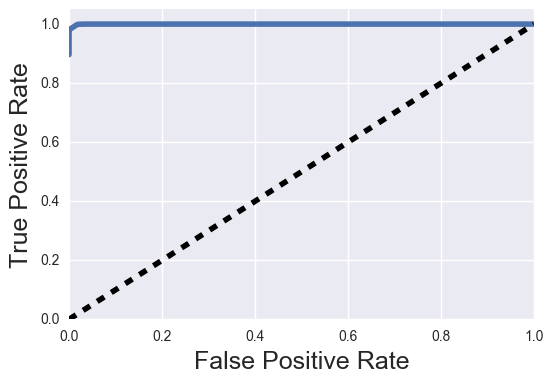

In [52]:
from sklearn.metrics import roc_curve, auc

FPR = dict()
TPR = dict()
ROC_AUC = dict()

FPR[1], TPR[1], _ = roc_curve(y, y_preds[:, 1]) #probabilities[:, 1]
ROC_AUC[1] = auc(FPR[1], TPR[1])


plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.show()

In [53]:
#I think this model is doing a bit too well, it doesn't look right. 

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 3. What is the score of a post?

---

**3.1 Build a model that predicts the score of a post.**

- This is a regression problem now. 
- You can and should be predicting score for both "question" and "answer" posts, so keep them both in your dataset.
- Again, use any techniques that you think will get you the best model.

**3.2 Evaluate the performance of your model with cross-validation and report the results.**

**3.3 What is important for determining the score of a post, if anything?**


In [57]:
X = X = posts_df[['HaveTags', 'HaveBody', 'PostTypeId']]
X = pd.DataFrame(np.hstack((X, body_col_to_use, tag_col_to_use)))
y = posts_df['Score'] #Target

In [58]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
rfr = RandomForestRegressor()

In [59]:
rfr.fit(X, y)
rfr_scores = cross_val_score(rfr, X, y, cv=10)
rfr_scores, np.mean(rfr_scores)

(array([-0.02329025, -0.15971181, -0.06583227, -0.15706296, -0.1432468 ,
        -0.3281556 , -0.1674683 , -0.09453849, -0.12281675, -0.09038346]),
 -0.13525066937847435)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 4. How many views does a post have?

---

**4.1 Build a model that predicts the number of views a post has.**

- This is another regression problem. 
- Predict the views for all posts, not just the "answer" posts.

**4.2 Evaluate the performance of your model with cross-validation and report the results.**

**4.3 What is important for the number of views a post has, if anything?**

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 5. Build a pipeline or other code to automate evaluation of your models on the test data.

---

Now that you've constructed your three predictive models, build a pipeline or code that can easily load up the raw testing data and evaluate your models on it.

The testing data that is held out is in the same raw format as the training data you have. _Any cleaning and preprocessing that you did on the training data will need to be done on the testing data as well!_

This is a good opportunity to practice building pipelines, but you're not required to. Custom functions and classes are fine as long as they are able to process and test the new data.


<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 6. Lets Model - Tournament for stock market predictions

>Start this section of the project by downloading the train and test datasets from the following site: https://numer.ai/rules

> - The data set is clean, your goal is to develop a classification model(s) 
> - Report all the results including log loss, and other coefficients you consider iteresting